<a href="https://colab.research.google.com/github/utsavdarlami/learning_pytorch/blob/main/segmentation/trying_unet_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

## Resources
### Video
- [*Paper Review*: U-Net: Convolutional Networks for Biomedical Image Segmentation](https://www.youtube.com/watch?v=oLvmLJkmXuc)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CODEDIR = "./drive/MyDrive/codes/"
CODEDIR

'./drive/MyDrive/codes/'

In [ ]:
!ls "./drive/MyDrive/codes/"

hello.py		  kaggle.json	   test_images
image_captioning.pth.tar  load_dataset.sh  unet_model.pth.tar


In [ ]:
!mkdir -p ~/.kaggle
!cp ./drive/MyDrive/codes/kaggle.json ~/.kaggle/

In [ ]:
## Create load_dataset.sh and add the bash code given below to that bash script 
"""
#!/bin/bash

files=("train.zip"
       "train_hq.zip"
       "train_masks.zip"
       "train_masks.csv.zip")

for file in ${files[*]}
do
    echo $file
    kaggle competitions download -c carvana-image-masking-challenge -f $file
done
"""

'\n#!/bin/bash\n\nfiles=("train.zip"\n       "train_hq.zip"\n       "train_masks.zip"\n       "train_masks.csv.zip")\n\nfor file in ${files[*]}\ndo\n    echo $file\n    kaggle competitions download -c carvana-image-masking-challenge -f $file\ndone\n'

In [ ]:
!bash load_dataset.sh

train.zip
 99% 401M/405M [00:04<00:00, 95.0MB/s]
100% 405M/405M [00:04<00:00, 87.7MB/s]
train_hq.zip
 98% 792M/804M [00:07<00:00, 91.8MB/s]
100% 804M/804M [00:07<00:00, 118MB/s] 
train_masks.zip
 31% 9.00M/29.1M [00:00<00:01, 19.1MB/s]
100% 29.1M/29.1M [00:00<00:00, 45.9MB/s]
train_masks.csv.zip
 59% 9.00M/15.3M [00:00<00:00, 36.2MB/s]
100% 15.3M/15.3M [00:00<00:00, 51.0MB/s]


In [ ]:
# Unzip the folders 
!unzip ./train.zip
!unzip ./train_masks.zip

In [ ]:
!unzip ./train_masks.csv.zip

Archive:  ./train_masks.csv.zip
  inflating: train_masks.csv         


## Let's GO

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_masks_csv = pd.read_csv("train_masks.csv")
train_masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [ ]:
len(train_masks_csv)

5088

In [ ]:
import torch
torch.__version__

'1.7.1+cu101'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Looking into data

In [ ]:
from PIL import Image, ImageMath
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
!pwd
# !ls /kaggle/working/

/content


In [ ]:
train_dir = "./train/"
train_mask_dir = "./train_masks/"
print(os.listdir(train_dir)[0])

3f3e362dea23_07.jpg


In [ ]:
len(os.listdir(train_dir))

5088

./train/00087a6bd4dc_01.jpg
./train_masks/00087a6bd4dc_01_mask.gif


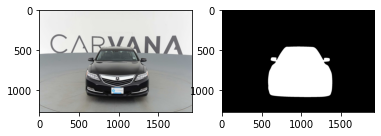

In [ ]:
image_1_name = train_masks_csv["img"][0] # os.listdir(train_dir)[0]

image_1_path = train_dir + image_1_name
image_1_mask_path = train_mask_dir + image_1_name.replace(".jpg", "_mask.gif")

print(image_1_path)
print(image_1_mask_path)

fig, axs = plt.subplots(1,2)

image_1 = Image.open(image_1_path).convert("RGB")
image_1_mask = Image.open(image_1_mask_path)#.convert("L")

axs[0].imshow(image_1)
axs[1].imshow(image_1_mask)

In [ ]:
def get_image_matrix(image_path):
    img = Image.open(image_path)
    return np.asarray(img, dtype=np.uint8)

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


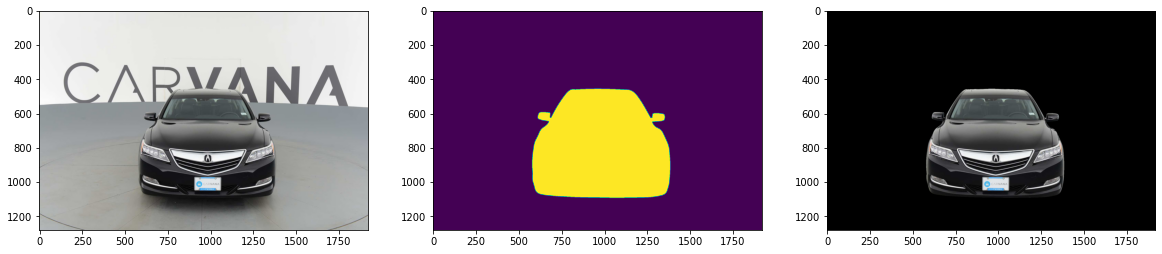

In [ ]:

plt.figure(figsize=(20, 20))
img = get_image_matrix(image_1_path)
mask = get_image_matrix(image_1_mask_path)
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}"
      .format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked);



In [ ]:
np.array(image_1).shape

(1280, 1918, 3)

In [ ]:
image_1_name.replace(".jpg", "_mask.gif")

'00087a6bd4dc_01_mask.gif'

In [ ]:
np.array(image_1_mask).shape

(1280, 1918)

In [ ]:
np.array(image_1_mask).max()

1

## Let's Create A Dataset and DataLoader 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
class CarvanaDataset(Dataset):
    
    def __init__(self, csv_path, img_dir, masks_dir, transform=None):
        super(CarvanaDataset, self).__init__()
        
        self.img_csv = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_csv)
    
    def __getitem__(self, idx):
        
        image_name  = self.img_csv['img'][idx]
        image_path = self.img_dir + image_name
        image_mask_path = self.masks_dir  + image_name.replace(".jpg", "_mask.gif")
        
        img = np.array(Image.open(image_path).convert("RGB"))
        img_mask = np.array(Image.open(image_mask_path).convert("L"), dtype=np.float32)
        img_mask[img_mask == 255.0] = 1.0
#         img_tensor = torch.tensor(img)
#         img_mask_tensor = torch.tensor(img_mask)
        
        if self.transform:
            img_tensor = self.transform(img)
            img_mask_tensor = self.transform(img_mask)

        
        return img_tensor, img_mask_tensor

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Resize((200,200)),
])

carvana_dataset = CarvanaDataset("./train_masks.csv", 
                                 img_dir = "./train/",
                                 masks_dir = "./train_masks/",
                                 transform=transform
)

In [ ]:
NUM_WORKERS = 2
PIN_MEMORY = True
BATCH_SIZE = 16
carvana_loader = DataLoader(carvana_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY,
                            shuffle=True
                            )

In [ ]:
for x, y in carvana_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([16, 3, 200, 200])
torch.Size([16, 1, 200, 200])


In [ ]:
print(y.squeeze(1).min())
y.squeeze(1).max()

tensor(0.)


tensor(1.)


### Showing a batch

In [ ]:
def show_batch_img(batch_x, x_ax=2, y_ax=2):
    fig, axs = plt.subplots(x_ax,y_ax, figsize=(10,10))
    idx=0
    for i in range(x_ax):
        for j in range(y_ax):
            axs[i][j].imshow(batch_x[idx])
            axs[i][j].axis("off")

            idx+=1


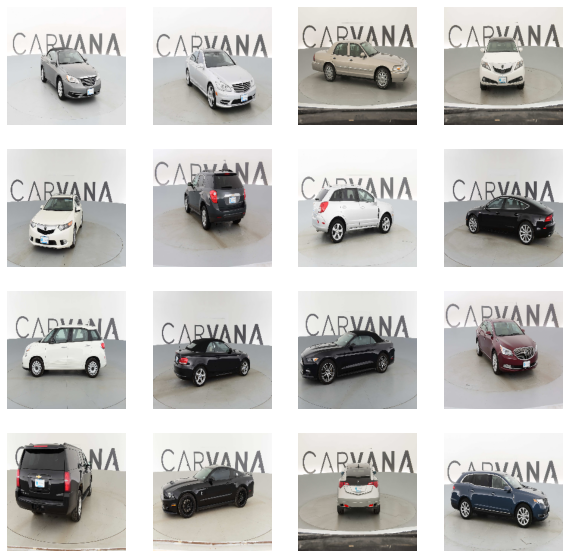

In [ ]:
show_batch_img(x.permute(0,2,3,1), x_ax=4, y_ax=4)

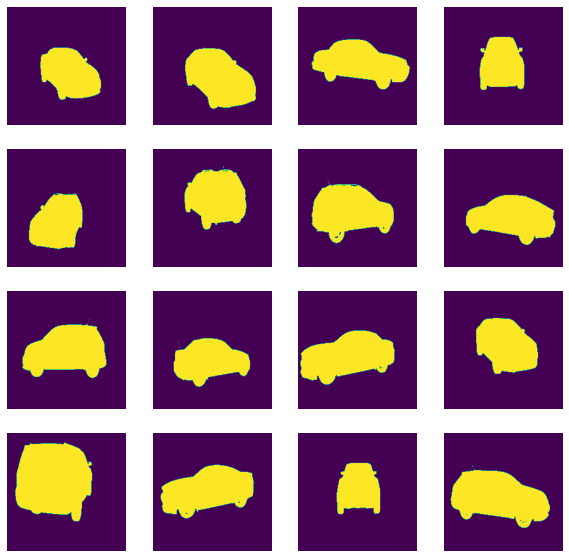

In [ ]:
show_batch_img(y.squeeze(1), x_ax=4, y_ax=4)

In [ ]:
len(carvana_loader)

318

# Let's Make U-Net Architecture

- Downsampling Module
    - 2 * Conv2d --> MaxPool2D --> repeat
- Upsampling Module
    - 1 * TransposeConv2d --> Concat --> 2 * Conv2d --> repeat

In [ ]:
from torch import nn
from torch import optim


### DOuble conv2d

In [ ]:
class DoubleConv2d(nn.Module):
    """
        Abstracting the Double Conv2D for both outsampling and upsampling.
    """
    def __init__(self, in_channel, out_channel):
        super(DoubleConv2d, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3,stride=1,
                               padding=1, bias=False) # padding 1 for the same conv
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3,stride=1,
                               padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)

        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        return x

In [ ]:

x_dummy = torch.rand(1, 3, 20, 20)


In [ ]:
## Testing this double conv 
double_conv2d = DoubleConv2d(3,64)
y_dummy = double_conv2d(x_dummy)
print(y_dummy.mean())

tensor(0.3980, grad_fn=<MeanBackward0>)


In [ ]:
channels = [64, 128, 256, 512]
for o_c in reversed(channels):
    print(f"{2*o_c} * {o_c}")

1024 * 512
512 * 256
256 * 128
128 * 64



### UNet

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        
        self.channels = [64, 128, 256, 512]
        self.in_channel = in_channel
        self.out_channel = out_channel
        

        self.downsampling = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsampling = nn.ModuleList()
        
        for out_channel in self.channels:
            self.downsampling.append(DoubleConv2d(in_channel,out_channel))
#             self.downsampling.append(self.maxpool)
            in_channel = out_channel
        
        self.turning_layer = DoubleConv2d(self.channels[-1], self.channels[-1]*2)
        
        for out_channel in reversed(self.channels):
            self.upsampling.append(nn.ConvTranspose2d(out_channel*2, 
                                                      out_channel, 
                                                      kernel_size=2,
                                                      stride=2
                                                     ))
            
            self.upsampling.append(DoubleConv2d(out_channel*2,
                                               out_channel))
        
        self.output_layer = nn.Conv2d(in_channels=self.channels[0], 
                                      out_channels=self.out_channel, 
                                      kernel_size=1, 
                                      stride=1)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        copied_feature_maps = []

        for down_layer in self.downsampling:
            x = down_layer(x)
            copied_feature_maps.append(x)
            x = self.maxpool(x)

        x = self.turning_layer(x)

        reversed_feature_maps = copied_feature_maps[::-1]

        for l_idx, up_layer in enumerate(self.upsampling):
            x = up_layer(x)

            if l_idx%2==0:

                feature_map = reversed_feature_maps[l_idx//2]
                
                if x.shape != feature_map.shape:
                    x = transforms.functional.resize(x, size=feature_map.shape[2:])
                
                x = torch.cat((feature_map, x), dim=1)
        
        x = self.output_layer(x)
        
        return x

In [ ]:
# checking concat function
a = torch.rand(1,512,200,200)
b = torch.rand(1,512,200,200)
c = torch.cat((a,b),dim=1)
c.shape

torch.Size([1, 1024, 200, 200])

In [ ]:
copy = unet.copied_feature_map[::-1]
for b in copy:
    print(b.shape)
    break

torch.Size([1, 512, 40, 40])


In [ ]:
max_before_turn = unet.maxpool(b)
max_before_turn.shape

torch.Size([1, 512, 20, 20])

In [ ]:
turned = unet.turning_layer(max_before_turn)
turned.shape

torch.Size([1, 1024, 20, 20])

In [ ]:
a = unet.upsampling[0](turned)
a.shape

torch.Size([1, 512, 19, 19])

In [ ]:
test_transpose = nn.ConvTranspose2d(512*2, 512, kernel_size=2, stride=2)
a_test = test_transpose(turned)
a_test.shape

torch.Size([1, 512, 40, 40])

In [ ]:
in_img = torch.rand(1,3,200,200)
unet_dummy = UNet(3,1)
segmented = unet_dummy(in_img)
print(segmented.mean())

tensor(0.0549, grad_fn=<MeanBackward0>)


# Now getting ready for training

In [ ]:
LEARNING_RATE = 1e-4

IN_CHANNEL = 3
OUT_CHANNEL = 1

NUM_EPOCHS = 5
# from model import UNET

In [ ]:
torch.cuda.empty_cache()


## Model Initialized

In [ ]:
unet_model = UNet(in_channel=IN_CHANNEL, out_channel=OUT_CHANNEL).to(device)
# unet_model = UNET().to(device)

In [ ]:
optimizer = optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss() 
scaler = torch.cuda.amp.GradScaler()

- We used BCEWithLogitsLoss because there is only 1 object to segment. 0/1 -> background/object
- This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss

### Training loop

In [ ]:
from tqdm import tqdm
NUM_EPOCHS = 5

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler, epoch):
    
    loop = tqdm(enumerate(loader), total=len(loader), leave=True, position=0)
    dice_score = 0
    for batch_idx, (imgs, masks) in loop:
        imgs = imgs.to(device)
        masks = masks.float().to(device)        
        
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            out_masks = model(imgs)
            loss = loss_fn(out_masks, masks)
            # dice_score += dice_score_fn(masks, out_masks)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item())  # Also add the model evaluation     
    # loop.set_postfix(loss=loss.item(), dice_score=dice_score.item()/len(loader))  # Also add the model evaluation     


In [ ]:
unet_model.train()
for epoch in range(NUM_EPOCHS):
    train_fn(carvana_loader, unet_model, optimizer, criterion, scaler, epoch)

Epoch [2/3]: 100%|██████████| 318/318 [05:03<00:00,  1.05it/s, loss=0.0334]



## Evaluating
##### Dice Score
- Easy to differentiate
- For Image = $\frac{2*\sum{\hat{y}*y}} {\sum{\hat{y} + y}}$
- priortise both precision and recall equally
- Loss = 1 - Dice


In [ ]:
def dice_score_fn(y, preds):
    with torch.no_grad():
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()
        intersection = (preds * y).sum()
        union = (preds + y).sum()
        dice_score = (2 * intersection) / (union + 1e-8)
    return dice_score

# print(f"Dice score: {dice_score/len(carvana_loader)}")

In [ ]:
dice_score = 0
unet_model.eval()

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(carvana_loader):
        x = x.to(device)
        y = y.to(device).unsqueeze(1)
        preds = torch.sigmoid(unet_model(x))
        preds = (preds > 0.5).float()
        dice_score += (2 * (preds * y).sum()) / (
            (preds + y).sum() + 1e-8
        )
        # if batch_idx==50:
        #     break 
        
print(f"Dice score: {dice_score/len(carvana_loader)}")



Dice score: 0.6722505688667297


## Saving the model

In [ ]:
CODEDIR

'./drive/MyDrive/codes/'

In [ ]:
#
checkpoint_path = CODEDIR + "unet_model.pth.tar"

In [ ]:
checkpoint = {
    "state_dict": unet_model.state_dict(),
    "optimizer": optimizer.state_dict(),
}

torch.save(checkpoint, checkpoint_path)

## Loading the model

In [ ]:
loaded_checkpoint = torch.load(checkpoint_path)

In [ ]:
unet_model.load_state_dict(loaded_checkpoint["state_dict"])
optimizer.load_state_dict(loaded_checkpoint["optimizer"])

## Looking into results

In [ ]:
test_transform = transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
])

def get_image_tensor(image_path, transform):
    image_1 = Image.open(image_path).convert("RGB")
    return transform(image_1)

def get_pred_mask(image_tensor):
    unet_model.eval()
    pred_mask = torch.sigmoid(unet_model(image_tensor.to(device)))
    return pred_mask

def plot_mask(ax, mask, threshold=None):
    pred_mask = mask.detach().squeeze().cpu()
    if threshold:
        ax.imshow(pred_mask.detach() > threshold)
    else:
        ax.imshow(pred_mask.detach())

def plot_img(img):
    img = img.cpu().permute(1,2,0)
    plt.imshow(img)

def apply_bitwise_and(images, masks):
    out = []
    # plt.figure(figsize=(20, 20))

        # return np.asarray(img, dtype=np.uint8)
    for image, mask in zip(images, masks):
        image_s = image.cpu().permute(1,2,0).numpy()
        # plt.subplot(131)
        # plt.imshow(image_s)
        
        mask_s = np.asarray(mask.detach().numpy(), dtype=np.uint8)
        # plt.subplot(132)
        # plt.imshow(mask_s)

        bitwise_img_mask = cv2.bitwise_and(image_s,image_s,mask=mask_s)
        # print(f"Image shape: {image.shape} | image type: {image.dtype} \
        # | mask shape: {mask.shape} | mask type: {mask.dtype}")
        
        # plt.subplot(133)
        # plt.imshow(bitwise_img_mask)

        out.append(bitwise_img_mask)
        # break
    print("done ")
    return out

# dice_score_fn


In [ ]:
for im, mask in carvana_loader:
    print(im.shape)
    print(mask.shape)
    break

torch.Size([16, 3, 200, 200])
torch.Size([16, 1, 200, 200])


In [ ]:
unet_model.eval()

with torch.no_grad():
    preds = torch.sigmoid(unet_model(im.to(device=device)))

unet_model.train()
preds = preds.detach().cpu().squeeze(1).float()

print(preds.shape)

torch.Size([16, 200, 200])


In [ ]:
print(preds.min())
preds.max()

tensor(0.0089)


tensor(1.0000)


### Predicted Mask of a single training batch

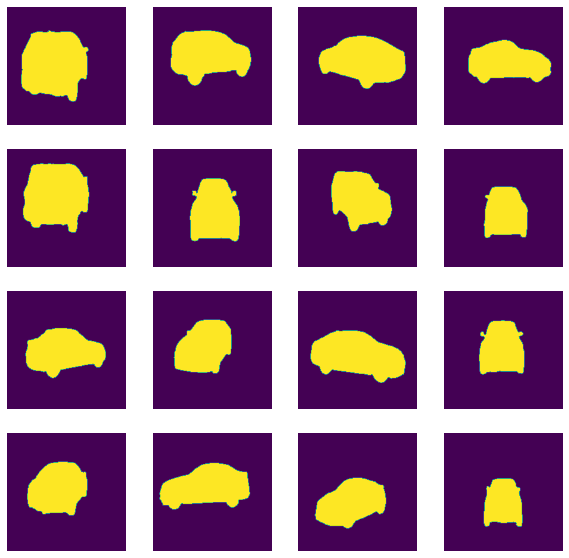

In [ ]:
show_batch_img(preds>0.5, 
               x_ax=4, y_ax=4)

In [ ]:
print(mask.squeeze(1).min())
mask.squeeze(1).max()

tensor(0.)


tensor(1.)

### True Mask

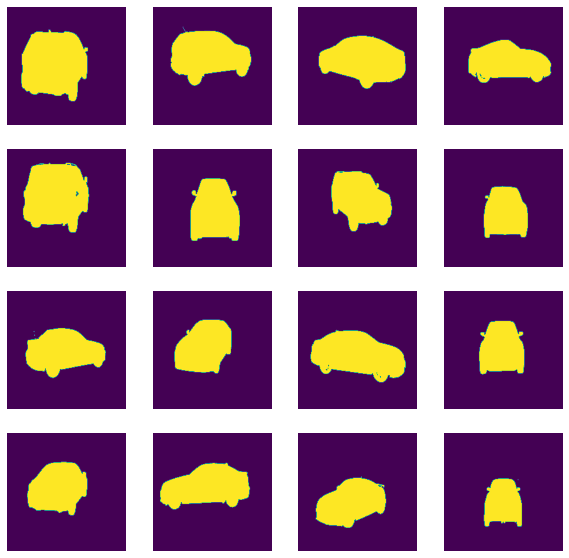

In [ ]:
show_batch_img(mask.squeeze(1), x_ax=4, y_ax=4)

In [ ]:
mask.permute(0,2,3,1).shape

torch.Size([16, 200, 200, 1])

In [ ]:
im.permute(0,2,3,1).shape

torch.Size([16, 200, 200, 3])

### Bitwise operation on pred mask and true image

In [ ]:
outs = apply_bitwise_and(im, (preds>0.5).squeeze(1))

done 


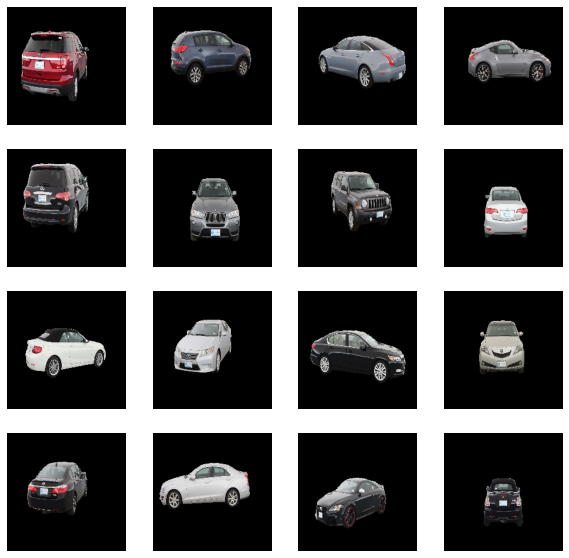

In [ ]:
show_batch_img(outs, x_ax=4, y_ax=4)

### True batch image

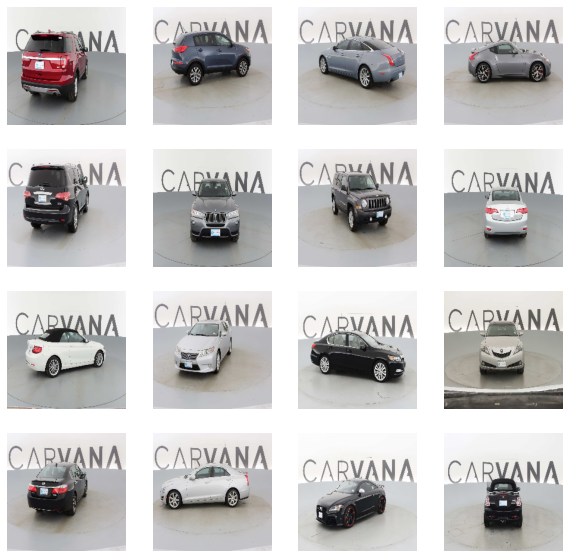

In [ ]:
show_batch_img(im.permute(0,2,3,1), x_ax=4, y_ax=4)

## Caculating the rle mask

In [ ]:
# from https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)
  

./train/00087a6bd4dc_01.jpg
./train_masks/00087a6bd4dc_01_mask.gif
(1918, 1280)


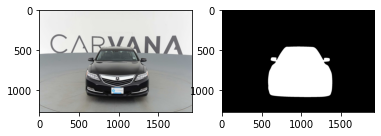

In [ ]:
image_1_name = train_masks_csv["img"][0] # os.listdir(train_dir)[0]

image_1_path = train_dir + image_1_name
image_1_mask_path = train_mask_dir + image_1_name.replace(".jpg", "_mask.gif")

print(image_1_path)
print(image_1_mask_path)

fig, axs = plt.subplots(1,2)

image_1 = Image.open(image_1_path).convert("RGB")
image_1_mask = Image.open(image_1_mask_path)#.convert("L")
print(image_1.size)
axs[0].imshow(image_1)
axs[1].imshow(image_1_mask)

In [ ]:
train_masks_csv.head(1)

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...


In [ ]:
img_1_rle =  train_masks_csv["rle_mask"][0]
print(len(img_1_rle))

8213


True


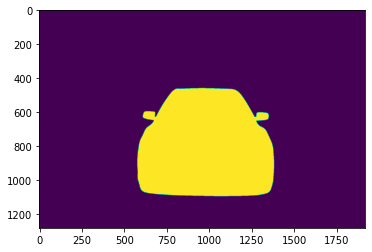

In [ ]:
rle_to_mask_1 = rle_decode(img_1_rle, (1280, 1918))
plt.imshow(rle_to_mask_1)
mask_to_rle_1 = rle_encode(rle_to_mask_1)
print(img_1_rle == mask_to_rle_1)

In [ ]:
def obtain_rle(masks):
    out = []
    rles = []
    for mask in masks:
        mask_s = np.asarray(mask.detach().numpy(), dtype=np.uint8)
        
        mask_to_rle_1 = rle_encode(mask_s)
    
        rle_to_mask_1 = rle_decode(mask_to_rle_1, (200, 200))
        
        out.append(rle_to_mask_1)
        rles.append(mask_to_rle_1)

    return out, rles

In [ ]:
obtained_masks, _ = obtain_rle((preds>0.5).squeeze(1))

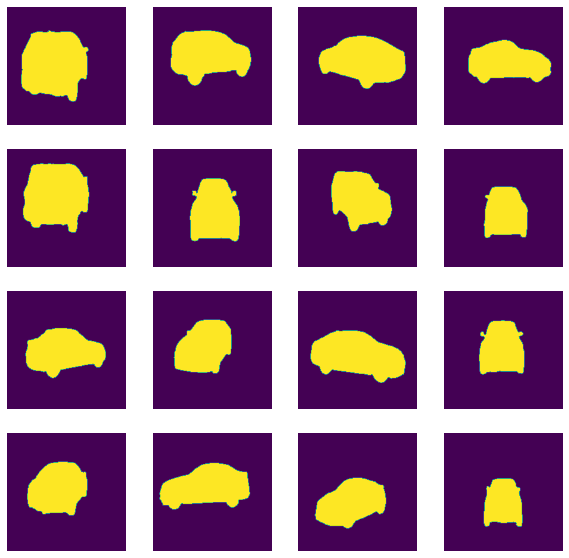

In [ ]:
show_batch_img(obtained_masks, x_ax=4, y_ax=4)

# Perparing For Submission


In [ ]:
# !kaggle competitions download -c carvana-image-masking-challenge -f test.zip
# !kaggle competitions download -c carvana-image-masking-challenge -f sample_submission.csv.zip

100% 7.74G/7.76G [02:58<00:00, 57.3MB/s]
100% 7.76G/7.76G [02:58<00:00, 46.6MB/s]
  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 65.7MB/s]


In [ ]:
# !unzip test.zip
# !unzip sample_submission.csv.zip

In [ ]:
# sample_sub = pd.read_csv("./sample_submission.csv")
# sample_sub.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [ ]:
# test_dir = "./test/"
# # topos.listdir()

./test/0004d4463b50_05.jpg


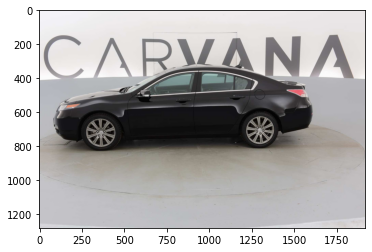

In [ ]:
# image_1_name = sample_sub["img"][4] # os.listdir(train_dir)[0]

# image_1_path = test_dir + image_1_name
# print(image_1_path)
# image_1 = np.array(Image.open(image_1_path).convert("RGB"))
# plt.imshow(image_1)

In [ ]:
image_1_tensor = get_image_tensor(image_1_path, test_transform)
image_1_tensor.shape

torch.Size([3, 200, 200])

In [ ]:
unet_model.eval()
image_1_tensor = image_1_tensor.unsqueeze(0).to(device)
pred_mask = unet_model(image_1_tensor)
pred_mask.shape

torch.Size([1, 1, 200, 200])

In [ ]:
pred_mask.squeeze(0).cpu().shape

torch.Size([200, 200])

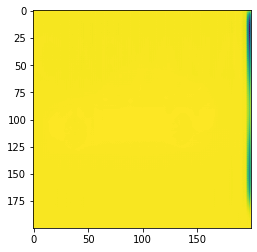

In [ ]:
pred_mask = pred_mask.squeeze().cpu()
plt.imshow(pred_mask.detach().numpy())